In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import folium

In [2]:
train = pd.read_csv("Datasets/train.csv")
test = pd.read_csv("Datasets/test.csv")
mrtExistingDf = pd.read_csv("Datasets/auxiliary-data/sg-mrt-existing-stations.csv")

In [3]:
print(mrtExistingDf.info())
mrtExistingDf.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   code          162 non-null    object 
 1   name          162 non-null    object 
 2   opening_year  162 non-null    int64  
 3   latitude      162 non-null    float64
 4   longitude     162 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 6.5+ KB
None


,code,name,opening_year,latitude,longitude
0,NS1,Jurong East,1990,1.333295,103.742154
1,NS2,Bukit Batok,1990,1.349035,103.749526
2,NS3,Bukit Gombak,1990,1.358663,103.751913
3,NS4,Choa Chu Kang,1990,1.385363,103.744371
4,NS5,Yew Tee,1996,1.397476,103.747418


In [4]:
mrtExistingDf.drop_duplicates()

,code,name,opening_year,latitude,longitude
0,NS1,Jurong East,1990,1.333295,103.742154
1,NS2,Bukit Batok,1990,1.349035,103.749526
2,NS3,Bukit Gombak,1990,1.358663,103.751913
3,NS4,Choa Chu Kang,1990,1.385363,103.744371
4,NS5,Yew Tee,1996,1.397476,103.747418
...,...,...,...,...,...
157,TE17,Outram Park,2022,1.280242,103.840052
158,TE18,Maxwell,2022,1.280533,103.843884
159,TE19,Shenton Way,2022,1.277717,103.850368
160,TE20,Marina Bay,2022,1.276311,103.854605


In [5]:
train['rent_approval_date']

0        2021-09
1        2022-05
2        2022-10
3        2021-08
4        2022-11
          ...   
59995    2021-09
59996    2023-04
59997    2022-06
59998    2023-01
59999    2023-02
Name: rent_approval_date, Length: 60000, dtype: object

In [6]:
# From string to period object.
train['rent_approval_date'] = pd.to_datetime(train['rent_approval_date'], format='%Y-%M')
mrtExistingDf['opening_year'] = pd.to_datetime(mrtExistingDf['opening_year'], format='%Y')

In [7]:
import pandas as pd
from geopy.distance import geodesic
from tqdm import tqdm

def compute_nearest_MRT(lat, long, mrt_df):
    filtered_mrt = mrt_df[mrt_df['opening_year'] <= row['rent_approval_date']]
    if filtered_mrt.empty:
        return "None", 1000000000, 0

    filtered_mrt["distance"] = filtered_mrt.apply(lambda row: geodesic((lat, long), (row["latitude"], row["longitude"])).kilometers, axis=1)
    
    MRT_1km = len(filtered_mrt[filtered_mrt["distance"] < 1])
    nearest_row = filtered_mrt.nsmallest(1, "distance").iloc[0]
    
    return nearest_row["name"], nearest_row["distance"], MRT_1km

train["MRT_1km"] = 0
train["nearest_MRT_name"] = "None"
train["nearest_MRT_dis"] = 1000000000

for index, row in tqdm(train.iterrows(), total=len(train)):
    nearest_MRT_name, nearest_MRT_dis, MRT_1km = compute_nearest_MRT(row["latitude"], row["longitude"], mrtExistingDf)
    train.at[index, "MRT_1km"] = MRT_1km
    train.at[index, "nearest_MRT_dis"] = nearest_MRT_dis
    train.at[index, "nearest_MRT_name"] = nearest_MRT_name

# train.to_csv("Datasets/with-mrt-train.csv", index=False)

  0%|          | 0/60000 [00:00<?, ?it/s]d:\software\anaconda\envs\cs5242\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
  2%|▏         | 1215/60000 [00:41<33:41, 29.08it/s]


KeyboardInterrupt: 

In [11]:
# Visualize and get the nearest MRT station existing
train["MRT_1km"] = train["longitude"]
train["nearest_MRT_name"] = train["longitude"]
train["nearest_MRT_dis"] = train["longitude"]
from geopy.distance import geodesic
for index in tqdm(train.index):
    latitude, longitude = train.loc[index, "latitude"], train.loc[index, "longitude"]
    nearest_MRT_dis = 1000000000
    nearest_MRT_name = "None"
    MRT_1km = 0
    for ind in mrtExistingDf.index:
        if mrtExistingDf.loc[ind, 'opening_year'] > train.loc[index, 'rent_approval_date']:
            # print("date due", mrtExistingDf.loc[ind, 'opening_year'], train.loc[index, 'rent_approval_date'])
            continue
        lat2, long2 = mrtExistingDf.loc[ind, "latitude"], mrtExistingDf.loc[ind, "longitude"]
        distance = geodesic((latitude, longitude), (lat2, long2)).kilometers
        if distance < 1:
            MRT_1km += 1
        if distance < nearest_MRT_dis:
            nearest_MRT_dis = distance
            nearest_MRT_name =  mrtExistingDf.loc[ind, "name"]
    train.loc[index, "MRT_1km"] = MRT_1km
    train.loc[index, "nearest_MRT_dis"] = nearest_MRT_dis
    train.loc[index, "nearest_MRT_name"] = nearest_MRT_name
# train.to_csv("Datasets/with-mrt-train.csv", index=False)

  0%|          | 0/60000 [00:00<?, ?it/s]

100%|██████████| 60000/60000 [37:28<00:00, 26.68it/s]


In [21]:
formal=pd.read_csv("Datasets/train.csv")
train=pd.read_csv("Datasets/with-mrt-train.csv")
train["rent_approval_date"]=formal["rent_approval_date"]


In [22]:
train.head(10)

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent,MRT_1km,nearest_MRT_name,nearest_MRT_dis
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600,1.0,Chinese Garden,0.699301
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250,1.0,Tanah Merah,0.899077
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900,4.0,Toa Payoh,0.218801
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850,0.0,Pasir Ris,1.547366
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100,3.0,Boon Keng,0.187930
5,2023-04,bukit panjang,654,Senja Road,executive,premium apartment,130.0,yes,2001,1.387847,103.764249,0.0,saujana,bukit panjang,west region,2300,1.0,Bukit Panjang,0.977449
6,2021-01,sengkang,407b,fernvale road,5 room,premium apartment,110.0,yes,2005,1.388997,103.875148,0.0,fernvale,sengkang,north-east region,2100,0.0,Buangkok,2.076772
7,2022-06,ang mo kio,223,ang mo kio avenue 1,3-room,new generation,67.0,yes,1978,1.366048,103.838123,0.0,shangri-la,ang mo kio,north-east region,2300,2.0,Mayflower,0.623279
8,2021-10,bishan,149,bishan street 11,4 room,simplified,84.0,yes,1987,1.344279,103.855556,0.0,bishan east,bishan,central region,2100,2.0,Bishan,0.964258
9,2021-04,punggol,133,edgedale plains,5 room,premium apartment,112.0,yes,2003,1.392832,103.910620,0.0,punggol field,punggol,north-east region,2100,0.0,Punggol,1.595781


In [23]:
def transform(x):
    if x<=0.3:
        return x+0.3
    else:
        return 0.9-x

transform=np.vectorize(transform)
train['nearest_MRT_dis']=transform(train['nearest_MRT_dis'])

In [24]:
train.head(10)

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent,MRT_1km,nearest_MRT_name,nearest_MRT_dis
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600,1.0,Chinese Garden,0.200699
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250,1.0,Tanah Merah,0.000923
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900,4.0,Toa Payoh,0.518801
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850,0.0,Pasir Ris,-0.647366
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100,3.0,Boon Keng,0.487930
5,2023-04,bukit panjang,654,Senja Road,executive,premium apartment,130.0,yes,2001,1.387847,103.764249,0.0,saujana,bukit panjang,west region,2300,1.0,Bukit Panjang,-0.077449
6,2021-01,sengkang,407b,fernvale road,5 room,premium apartment,110.0,yes,2005,1.388997,103.875148,0.0,fernvale,sengkang,north-east region,2100,0.0,Buangkok,-1.176772
7,2022-06,ang mo kio,223,ang mo kio avenue 1,3-room,new generation,67.0,yes,1978,1.366048,103.838123,0.0,shangri-la,ang mo kio,north-east region,2300,2.0,Mayflower,0.276721
8,2021-10,bishan,149,bishan street 11,4 room,simplified,84.0,yes,1987,1.344279,103.855556,0.0,bishan east,bishan,central region,2100,2.0,Bishan,-0.064258
9,2021-04,punggol,133,edgedale plains,5 room,premium apartment,112.0,yes,2003,1.392832,103.910620,0.0,punggol field,punggol,north-east region,2100,0.0,Punggol,-0.695781


In [28]:
train.to_csv("Datasets/with-mrt-train.csv", index=False)

In [33]:
train=pd.read_csv("Datasets/with-mrt-train.csv")
grouped=train.groupby('nearest_MRT_name')["monthly_rent"].mean()

train["mrt_average_price"]=train["nearest_MRT_name"].map(grouped)

In [35]:
train.to_csv("Datasets/with-mrt-train.csv", index=False)

In [34]:
train.head(10)

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent,MRT_1km,nearest_MRT_name,nearest_MRT_dis,mrt_average_price
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600,1.0,Chinese Garden,0.200699,2481.346424
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250,1.0,Tanah Merah,0.000923,2425.980392
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900,4.0,Toa Payoh,0.518801,2632.947462
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850,0.0,Pasir Ris,-0.647366,2687.550471
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100,3.0,Boon Keng,0.487930,2589.985486
5,2023-04,bukit panjang,654,Senja Road,executive,premium apartment,130.0,yes,2001,1.387847,103.764249,0.0,saujana,bukit panjang,west region,2300,1.0,Bukit Panjang,-0.077449,2509.859626
6,2021-01,sengkang,407b,fernvale road,5 room,premium apartment,110.0,yes,2005,1.388997,103.875148,0.0,fernvale,sengkang,north-east region,2100,0.0,Buangkok,-1.176772,2595.341463
7,2022-06,ang mo kio,223,ang mo kio avenue 1,3-room,new generation,67.0,yes,1978,1.366048,103.838123,0.0,shangri-la,ang mo kio,north-east region,2300,2.0,Mayflower,0.276721,2348.609272
8,2021-10,bishan,149,bishan street 11,4 room,simplified,84.0,yes,1987,1.344279,103.855556,0.0,bishan east,bishan,central region,2100,2.0,Bishan,-0.064258,2977.132701
9,2021-04,punggol,133,edgedale plains,5 room,premium apartment,112.0,yes,2003,1.392832,103.910620,0.0,punggol field,punggol,north-east region,2100,0.0,Punggol,-0.695781,2666.429094


In [9]:
MRT_info_slice = train[["MRT_1km", "nearest_MRT_dis", "nearest_MRT_name", "monthly_rent"]]
MRT_info_slice

,MRT_1km,nearest_MRT_dis,nearest_MRT_name,monthly_rent
0,1.0,11.258567,Chinese Garden,1600
1,1.0,9.776314,Tanah Merah,2250
2,4.0,6.420501,Toa Payoh,1900
3,0.0,14.201088,Pasir Ris,2850
4,3.0,4.668240,Boon Keng,2100
...,...,...,...,...
59995,1.0,3.566797,Ang Mo Kio,2200
59996,2.0,5.197697,Tiong Bahru,4100
59997,2.0,11.434808,Tampines,2250
59998,1.0,9.631031,Tanah Merah,4700


In [10]:
MRT_info_slice["monthly_rent"] = MRT_info_slice["monthly_rent"].astype(float)

<ipython-input-10-6ebdfa5024cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MRT_info_slice["monthly_rent"] = MRT_info_slice["monthly_rent"].astype(float)


In [11]:
correlation = MRT_info_slice["MRT_1km"].corr(MRT_info_slice["monthly_rent"])
correlation

0.09093094153543285

In [12]:
correlation = MRT_info_slice["nearest_MRT_dis"].corr(MRT_info_slice["monthly_rent"])
correlation

0.09924020679999522

In [13]:
group_MRT_2 = MRT_info_slice.groupby("nearest_MRT_name").mean()
group_MRT_2

,MRT_1km,nearest_MRT_dis,monthly_rent
nearest_MRT_name,,,
Admiralty,1.207281,16.535052,2502.786033
Aljunied,3.493243,4.962107,2511.993243
Ang Mo Kio,1.015531,7.527862,2461.518550
Bartley,1.830769,5.924237,2494.615385
Beauty World,1.000000,10.240808,2927.678571
...,...,...,...
Woodleigh,1.071429,4.773254,2491.071429
Yew Tee,1.125275,16.179465,2505.824176
Yio Chu Kang,2.010230,8.643270,2396.163683


In [14]:
print("There are {} existing unique MRT stations in the dataset however {} are not present in the grouped nearest stations set.".format(len(mrtExistingDf['name'].unique()), len(mrtExistingDf['name'].unique())-len(group_MRT_2)))

There are 134 existing unique MRT stations in the dataset however 38 are not present in the grouped nearest stations set.


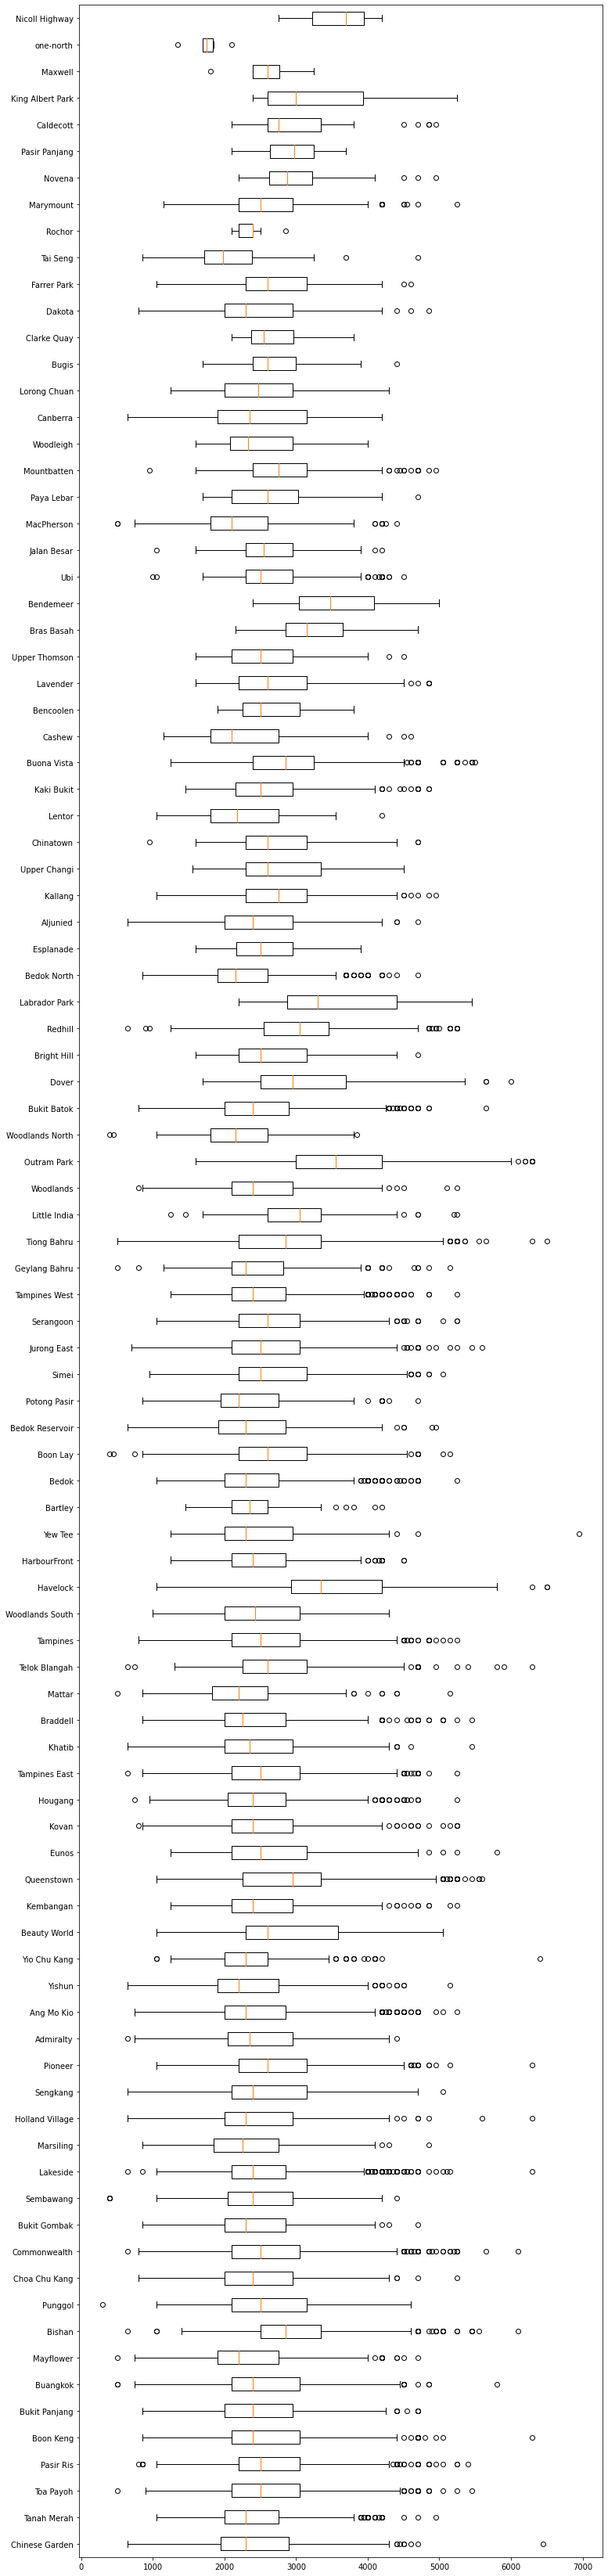

In [15]:
plt.figure(figsize=(12, 60))
MRTs = MRT_info_slice["nearest_MRT_name"].unique()
boxplot_data = []
for MRT in MRTs:
    boxplot_data.append(MRT_info_slice[MRT_info_slice["nearest_MRT_name"] == MRT]["monthly_rent"])

plt.boxplot(boxplot_data, labels=MRTs, vert=False)
plt.show()

In [16]:
mrt_loc_rent = group_MRT_2.merge(mrtExistingDf, left_on=group_MRT_2.index, right_on="name")
mrt_loc_rent

,MRT_1km,nearest_MRT_dis,monthly_rent,code,name,opening_year,latitude,longitude
0,1.207281,16.535052,2502.786033,NS10,Admiralty,1996-01-01,1.440556,103.800917
1,3.493243,4.962107,2511.993243,EW9,Aljunied,1989-01-01,1.316441,103.882964
2,1.015531,7.527862,2461.518550,NS16,Ang Mo Kio,1987-01-01,1.369933,103.849558
3,1.830769,5.924237,2494.615385,CC12,Bartley,2009-01-01,1.342445,103.880197
4,1.000000,10.240808,2927.678571,DT5,Beauty World,2015-01-01,1.340901,103.775747
...,...,...,...,...,...,...,...,...
106,1.071429,4.773254,2491.071429,NE11,Woodleigh,2011-01-01,1.339828,103.870961
107,1.125275,16.179465,2505.824176,NS5,Yew Tee,1996-01-01,1.397476,103.747418
108,2.010230,8.643270,2396.163683,NS15,Yio Chu Kang,1987-01-01,1.381683,103.844991
109,0.906207,14.299188,2358.275862,NS13,Yishun,1988-01-01,1.429589,103.835050


In [17]:
# The centroid of the map
m = folium.Map(location=[mrt_loc_rent['latitude'].mean(), mrt_loc_rent['longitude'].mean()], zoom_start=12)
for index, row in mrt_loc_rent.iterrows():
    marker = folium.Marker(
        location=[row['latitude'], row['longitude']],
        tooltip=row['name'],  # Mouse-on marker
    )
    popup = folium.Popup(f"Rental: {row['monthly_rent']}", parse_html=True,  permanent=True)
    popup.add_to(marker)
    marker.add_to(m)

m.save('mrt_map_with_price.html')  # HTML
m